In [1]:
import numpy as np
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import functional as SF
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm 
import psweep as ps # <--

import warnings # highly illegal move to make pandas compliant
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path

import utils_data, utils_spikes, utils_events, utils_tensor

# And now that we have a dataloader and a working network, we can sweep for a few parameters
### Meta parameters would be lr, beta, threshold
### Network parameters in a simple FF MLP would be depth, width

In [3]:
# Experiment specific parameters 
chip_id = 9501 # experiment ID
chip_session = 0 # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 10 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

# Torch parameters 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
len_trial = 100 # how long in bins is a trial (so in ms it's len_trial*binsize)

# Using our brand new dataloader

In [4]:
data_subset, events = utils_data.load_file(chip_id, chip_session, data_path)
spiketimes = utils_data.get_spiketimes(data_subset, array_size,fs)
sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes = utils_data.get_electrode_regions(data_subset, spiketimes, do_plot = False)

all_spikes = [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes]
# Find maximum time across all spike lists
max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in all_spikes)

# Create binned spikes tensor for each region
sensory_spikes_binned = utils_tensor.spike_times_to_bins(sensory_spikes, binsize, max_time_ms, spike_tag = 'sensory')
up1_spikes_binned = utils_tensor.spike_times_to_bins(up1_spikes, binsize, max_time_ms, spike_tag = 'up1')
down1_spikes_binned = utils_tensor.spike_times_to_bins(down1_spikes, binsize, max_time_ms, spike_tag='down1')
up2_spikes_binned = utils_tensor.spike_times_to_bins(up2_spikes, binsize, max_time_ms, spike_tag = 'up2')
down2_spikes_binned = utils_tensor.spike_times_to_bins(down2_spikes, binsize, max_time_ms, spike_tag = 'down2')

# Verifying that the tensor are binary files
utils_tensor.check_binary(sensory_spikes_binned, "sensory_spikes_binned")
utils_tensor.check_binary(up1_spikes_binned, "up1_spikes_binned")
utils_tensor.check_binary(down1_spikes_binned, "down1_spikes_binned")
utils_tensor.check_binary(up2_spikes_binned, "up2_spikes_binned")
utils_tensor.check_binary(down2_spikes_binned, "down2_spikes_binned")

Loading data...: 100%|██████████| 29/29 [00:00<00:00, 39.94it/s]


Stimulation mode: full game


Binning sensory channels: 100%|██████████| 500/500 [00:00<00:00, 1138.40it/s]
/media/hugo/HDD Alpha/github-hdd/BrainDishSiMulator/notebooks/../code/utils/utils_tensor.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(binned_spikes)
Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 1217.82it/s]


True

# A bit of preprocessing to get a nice PyTorch friendly format 

In [5]:
# Processing events
# Process everything so its nice and milliseconds
events[0]['event'] = 'motor layout: 0' # change the being game to motor layout for convenience 
for event in events:
    event['norm_timestamp'] /= fs  # fs to seconds 
    event['norm_timestamp'] *= 1000  # seconds to ms
    
event_types = ['ball missed', 'ball bounce', 'ball return', 'motor layout: 0'] # these are all the labels
labels = torch.tensor(utils_tensor.events_to_bins(events, event_types, 10, max_time_ms))
assert labels.shape[-1] == sensory_spikes_binned.shape[-1] # make sure the labels and the data are the same length

transformed_data, transformed_labels = utils_tensor.transform_data(labels, sensory_spikes_binned, len_trial) # change dataformat
assert transformed_data.shape[1] == transformed_labels.shape[0] # make sure the labels and the data have the same trials

# Create Dataset
dataset = utils_tensor.CustomDataset(transformed_data, transformed_labels)

# Now we define the network

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, beta=0.95):
        super().__init__()

        self.num_layers = len(num_hiddens)
        self.fcs = nn.ModuleList([nn.Linear(num_inputs if i==0 else num_hiddens[i-1], num_hiddens[i]) for i in range(self.num_layers)])
        self.lifs = nn.ModuleList([snn.Leaky(beta=beta) for _ in range(self.num_layers)])
        self.fc_out = nn.Linear(num_hiddens[-1], num_outputs)
        self.lif_out = snn.Leaky(beta=beta)

    def forward(self, x):
        mems = [lif.init_leaky() for lif in self.lifs]

        spk_rec = []
        mem_rec = []

        for step in range(x.size(1)):
            cur = x[:,step]
            for i in range(self.num_layers):
                cur = self.fcs[i](cur)
                spk, mems[i] = self.lifs[i](cur, mems[i])
                cur = spk

            out_spk, out_mem = self.lif_out(self.fc_out(cur), self.lif_out.init_leaky())
            spk_rec.append(out_spk)
            mem_rec.append(out_mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [7]:
def train_dishnet(params) :
    # Unpack the parameters from the dict 
    num_inputs = params['num_inputs']
    num_hiddens = params['num_hiddens']  # Changed to num_hiddens
    num_outputs = params['num_outputs']
    beta = params['beta']
    num_epochs = params['num_epochs']
    lr = params['lr']
    batch_size = params['batch_size']
    
    # Split the dataset into train and test sets
    dataset_size = len(dataset)
    train_size = int(dataset_size * 0.8)  # 80% for training
    test_size = dataset_size - train_size  # 20% for testing
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    dishnet = Net(num_inputs = num_inputs, num_hiddens = num_hiddens, num_outputs=num_outputs, beta = beta).to(device)  # Changed to num_hiddens

    loss_fn = SF.ce_count_loss()
    optimizer = torch.optim.Adam(dishnet.parameters(), lr=lr, betas=(0.9, 0.999))

    loss_hist = []
    test_loss_hist = []
    counter = 0

    # Outer training loop
    for epoch in tqdm(range(num_epochs)):
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            dishnet.train()
            spk_rec, _ = dishnet(data)

            # initialize the loss & sum over time
            loss_val = loss_fn(spk_rec, targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            counter += 1

            if counter == 100:
                break
        
        # Testing phase
        dishnet.eval()  # Set the model to evaluation mode
        with torch.no_grad(): 
            for data, targets in test_loader:
                data = data.to(device)
                targets = targets.to(device)

                # Forward pass
                spk_rec, _ = dishnet(data)

                # Compute loss value
                test_loss_val = loss_fn(spk_rec, targets)
                
                # Store test loss history
                test_loss_hist.append(test_loss_val.item())
                
    print('\n')
    return loss_hist, test_loss_hist  # returns train and test loss respectively

In [8]:
# Define the lists of values for each parameter you want to sweep over
num_inputs = ps.plist("num_inputs", [transformed_data.shape[-1]])

# Make multiple possible size for the input layers
size_hiddens = np.linspace(50, 1000, 3, dtype=int)
# Generate all possible combinations for 1, 2, and 3 layers.
hidden_layer_sizes_1 = [[size] for size in size_hiddens]
hidden_layer_sizes_2 = [[size1, size2] for size1 in size_hiddens for size2 in size_hiddens]
hidden_layer_sizes_3 = [[size1, size2, size3] for size1 in size_hiddens for size2 in size_hiddens for size3 in size_hiddens]

num_hiddens = ps.plist("num_hiddens", hidden_layer_sizes_1 + hidden_layer_sizes_2 + hidden_layer_sizes_3)

num_outputs = ps.plist("num_outputs", [len(event_types)])
beta = ps.plist("beta", [0.9])
num_epochs = ps.plist("num_epochs", [50])
lr = ps.plist("lr", [1e-3])
batch_size = ps.plist("batch_size", [32])

# Create the parameter grid
param_grid = ps.pgrid((num_inputs, num_hiddens, num_outputs, beta, num_epochs, lr, batch_size))

# Define a function to run one instance of the experiment
def run_experiment(params):
    train_loss, test_loss = train_dishnet(params)
    return {'train_loss': train_loss, 'test_loss': test_loss}

print("Running parameter sweep of length {}.".format(len(param_grid)))

# Run the parameter sweep
results = ps.run_local(run_experiment, param_grid, verbose = True)

Running parameter sweep of length 117.
                               batch_size  beta   lr  num_epochs num_hiddens  num_inputs  num_outputs
2023-07-07 17:34:56.442241907          32   0.9  0.1          50        [50]         500            4


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]




                               batch_size  beta    lr  num_epochs num_hiddens  num_inputs  num_outputs
2023-07-07 17:35:23.891287804          32   0.9  0.01          50        [50]         500            4


 82%|████████▏ | 41/50 [00:21<00:04,  1.81it/s]

In [ ]:
# Define a function to return the last test loss from each row
def final_test_loss(test_loss_list):
    return test_loss_list[-1]

# Apply the function to each row in 'test_loss' column, sort the DataFrame by the final test loss
results['final_test_loss'] = results['test_loss'].apply(final_test_loss)
results_sorted = results.sort_values(by=['final_test_loss'])

# Select the top 5 models
top_5_models = results_sorted.head(5)

# Plot the loss history for the top 5 models
for i, row in top_5_models.iterrows():
    plt.plot(row['test_loss'], label=f"Model {i}")

plt.title('Test Loss Curves for the Top 5 Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


KeyError: 'test_loss'

# Reloading only

In [ ]:
results_sorted.iloc[0]['train_loss']

'train_loss'

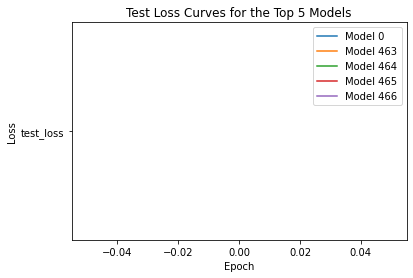

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

database_path = './calc/database.pk'

# load the database
results = pd.read_pickle(database_path)

# Define a function to return the last test loss from each row
def final_test_loss(test_loss_list):
    return test_loss_list[-1]

# Apply the function to each row in 'test_loss' column, sort the DataFrame by the final test loss
results['final_test_loss'] = results['test_loss'].apply(final_test_loss)
results_sorted = results.sort_values(by=['final_test_loss'])

# Select the top 5 models
top_5_models = results_sorted.head(5)

# Plot the loss history for the top 5 models
for i, row in top_5_models.iterrows():
    plt.plot(row['test_loss'], label=f"Model {i}")

plt.title('Test Loss Curves for the Top 5 Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
